In [1]:
import warnings
warnings.filterwarnings("ignore")
from keras import applications
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np
from os import listdir
from os.path import isfile, join
from PIL import Image
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
def img2arr(image):
    im_arr = np.fromstring(image.tobytes(), dtype=np.uint8)
    dep = (int) (im_arr.size / (image.size[0] * image.size[1]))
    if dep > 1:
        im_arr = im_arr.reshape((image.size[1], image.size[0], dep))
    else:
        im_arr = im_arr.reshape((image.size[1], image.size[0]))
    return im_arr

In [3]:
k.set_image_dim_ordering('tf')
img_width = 64
img_height = 64
train_data_dir = "data/train"
validation_data_dir = "data/valid"
nb_train_samples = 25
nb_validation_samples = 8
batch_size = 1
epochs = 10
num_of_classes = 2

In [4]:
# Loading base model.
model = VGG16(weights='imagenet', include_top=False,input_shape = (img_width, img_height,3))

In [5]:
for layer in model.layers[:-5]:
    layer.trainable = False

In [6]:
# ADDING FC LAYERS ON TOP OF VGG16..
top_layers = model.output
top_layers = Flatten(input_shape=model.output_shape[1:])(top_layers)
top_layers = Dense(128, activation="relu",input_shape=(num_of_classes,))(top_layers)
top_layers = Dropout(0.2)(top_layers)
top_layers = Dense(64, activation="relu",input_shape=(num_of_classes,))(top_layers)
top_layers = Dropout(0.2)(top_layers)
top_layers = Dense(num_of_classes, activation="relu",input_shape=(num_of_classes,))(top_layers)
top_layers = Dense(num_of_classes, activation="softmax")(top_layers)

In [7]:
model_final = Model(input = model.input, output = top_layers)

In [8]:
model_final.compile(loss = "binary_crossentropy", optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])

In [9]:
# Initialize test and training data
train_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = True,
fill_mode = "nearest",
zoom_range = 0.3,
width_shift_range = 0.3,
height_shift_range=0.3,
rotation_range=30)

test_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = True,
fill_mode = "nearest",
zoom_range = 0.3,
width_shift_range = 0.3,
height_shift_range=0.3,
rotation_range=30)

In [10]:
train_generator = train_datagen.flow_from_directory(
train_data_dir,
target_size = (img_height, img_width),
batch_size = batch_size, 
class_mode = "categorical")

validation_generator = test_datagen.flow_from_directory(
validation_data_dir, target_size = (img_height, img_width), class_mode = "categorical")

Found 27 images belonging to 2 classes.
Found 6 images belonging to 2 classes.


In [11]:
checkpoint = ModelCheckpoint("vgg16_mymodel.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')

In [19]:
model_final.fit_generator(
train_generator,
samples_per_epoch = nb_train_samples,
epochs = epochs,
validation_data = validation_generator,
nb_val_samples = nb_validation_samples,
callbacks = [checkpoint, early]
)

Epoch 1/10
24/25 [===========================>..] - ETA: 0s - loss: 0.4234 - acc: 0.8333
Epoch 00001: val_acc did not improve
25/25 [==============================] - 6s 240ms/step - loss: 0.4220 - acc: 0.8400 - val_loss: 0.5408 - val_acc: 0.7917
Epoch 2/10
24/25 [===========================>..] - ETA: 0s - loss: 0.4408 - acc: 0.8750
Epoch 00002: val_acc did not improve
25/25 [==============================] - 6s 238ms/step - loss: 0.4416 - acc: 0.8800 - val_loss: 0.4577 - val_acc: 0.8333
Epoch 3/10
24/25 [===========================>..] - ETA: 0s - loss: 0.3779 - acc: 0.7917
Epoch 00003: val_acc did not improve
25/25 [==============================] - 6s 232ms/step - loss: 0.4106 - acc: 0.7600 - val_loss: 0.4087 - val_acc: 0.8542
Epoch 4/10
24/25 [===========================>..] - ETA: 0s - loss: 0.3891 - acc: 0.8333
Epoch 00004: val_acc did not improve
25/25 [==============================] - 6s 241ms/step - loss: 0.3793 - acc: 0.8400 - val_loss: 0.3335 - val_acc: 0.8750
Epoch 5/10
2

In [13]:
# Okay, Training is done. Now, let's do testing.

In [13]:
test_path1 = "data/test/not"
test_path2 = "data/test/sure"

In [14]:
no = [f for f in listdir(test_path1) if isfile(join(test_path1, f))]
sure = [f for f in listdir(test_path2) if isfile(join(test_path2, f))]
print(no, sure)

['nt1.jpg', 'nt2.jpg', 'nt3.jpg', 'nt4.jpg'] ['st1.jpg', 'st2.jpg', 'st3.jpg', 'st4.jpg']


In [20]:
for i in no:
    test_image = image.load_img(test_path1 + "/" + i, target_size = (64, 64))
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis = 0)
    result = model_final.predict(test_image)
    if result[0][0] == 1:
        prediction = 'not'
    else:
        prediction = 'sure'
    print(prediction)

not
not
not
sure


In [35]:
#Whoa, 100% Accurate on TEST DATA on "not torn" shirts.

In [21]:
for i in sure:
    test_image = image.load_img(test_path2 + "/" + i, target_size = (64, 64))
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis = 0)
    result = model_final.predict(test_image)
    if result[0][0] == 1:
        prediction = 'not'
    else:
        prediction = 'sure'
    print(prediction)

not
sure
sure
sure


In [36]:
# 75% On "torn shirts".

In [37]:
"""
SO, OVERALL, BY LESS THAN 50 IMAGES OF TRAINING, MODEL PERFORMS GOOD.
"""

'\nSO, OVERALL, BY LESS THAN 50 IMAGES OF TRAINING, MODEL PERFORMS GOOD.\n'

In [40]:
for i in no:
    ima = Image.open(test_path1 + "/" + i)
    ima = img2arr(ima)
    
    print(ima.shape)

(259, 194, 3)
(277, 182, 3)
(256, 197, 3)
(225, 225, 3)


In [72]:
def removekey(d, key):
    r = dict(d)
    del r[key]
    return r

Full photo...............................................


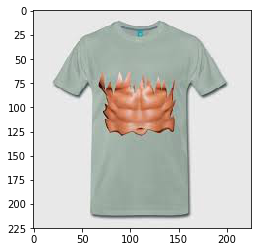

First 3 "relatively" most confident bounding box......................


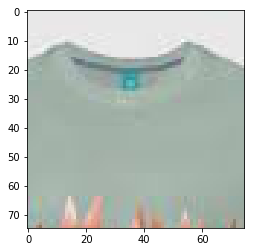

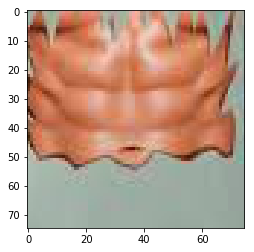

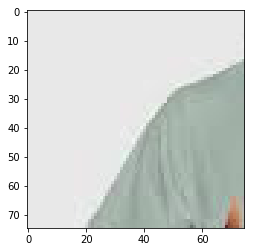

Full photo...............................................


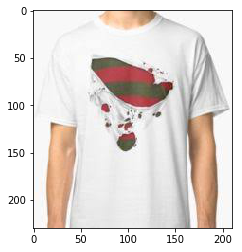

First 3 "relatively" most confident bounding box......................


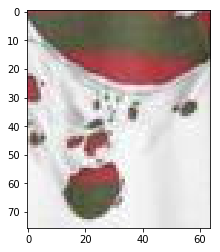

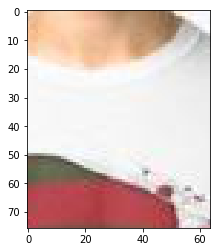

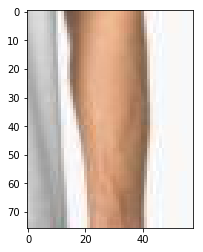

Full photo...............................................


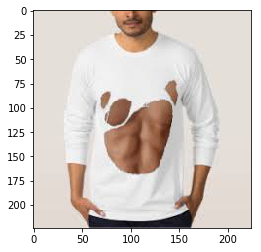

First 3 "relatively" most confident bounding box......................


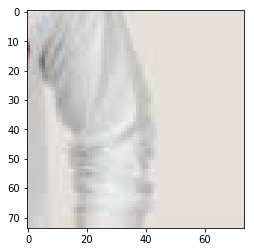

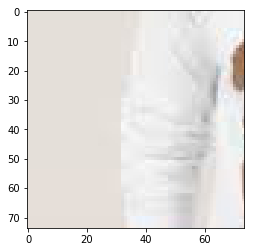

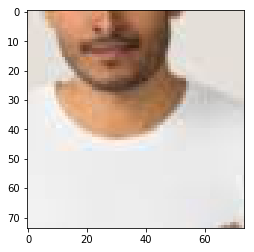

Full photo...............................................


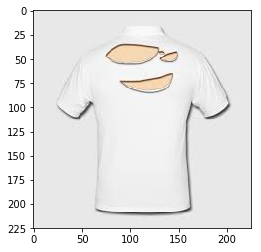

First 3 "relatively" most confident bounding box......................


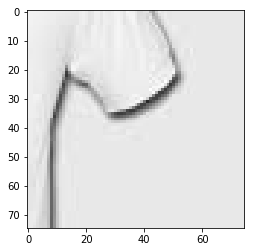

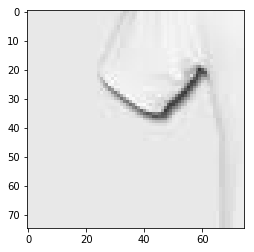

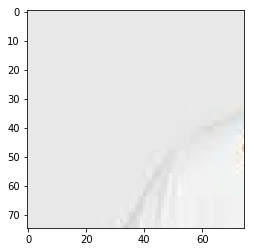

In [26]:
bbsize = 3     # bounding box size relative to total image size. Means, bounding box will 1/3rd of total image size.
for i in sure:         # run for only torn images. Because there is nothing to capture for non-torn images.
    """
    test_image = image.load_img(test_path2 + "/" + i, target_size = (64, 64))
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis = 0)
    result = model_final.predict(test_image)
    """
    ima = Image.open(test_path2 + "/" + i)   # Open full image.
    ima = img2arr(ima)    # convert it into array form..
    # print(ima.shape)
    wi, hi = ima.shape[0], ima.shape[1]    # get width and height
    bbwi, bbhi = wi // bbsize, hi // bbsize  # Bounding box width and height
    # print("bbwi : ", bbwi, " bbhi : ", bbhi)
    res_arr = {}    # dictionary to store ratio of confidence of is_torn and not_torn. More "LOGIC" detail below.
    part_arr = {}    # dictionary to store all bounding box.
    cnt = 0
    # run 2 nested for loops to run over all bounding box possible.
    for j in range(bbsize):
        for k in range(bbsize):
            # capture a specific bounding box part of image.
            paarr = ima[j * bbwi : (j + 1) * bbwi, k * bbwi : (k + 1) * bbhi, :]
            part_arr[cnt] = paarr
            # convert it in to image to visulize it and to find results.
            paimg = Image.fromarray(paarr, 'RGB')
            # print(paarr.shape)
            # some preprocessing..
            paimg.save("part.jpg")
            test_image = image.load_img("part.jpg", target_size = (64, 64))
            test_image = image.img_to_array(test_image)
            test_image = np.expand_dims(test_image, axis = 0)
            # predict probability and get the result array
            result = model_final.predict(test_image)
            """
                LOGIC:
                CREATE A DICTIONARY WITH VALUE WHICH WE GET BY DiVIDING "CONFIDENCE OF TORN" AND "CONFIDENCE OF NOT TRON".
                AND WE SORT THESE REVIDING RESULTS DESCENDING. AND PICK FIRST 3 BOUNDING BOX ACCORDING TO THAT.
            
            """
            res_arr[int(cnt)] = result[0][1] / result[0][0]
            cnt += 1
    # print(res_arr)
    # to get highest ratio score. Do sorting by value in dictionary.
    res_arr_list = [(k, res_arr[k]) for k in sorted(res_arr, key=res_arr.get, reverse=True)]
    # print(res_arr_list)
    # print(max_in)
    print("Full photo...............................................")
    plt.imshow(ima)
    plt.show()
    print("First 3 \"relatively\" most confident bounding box......................")
    for j, k in res_arr_list[:3]:             # To show first 3 most confident images..
        paarr = part_arr[j]
        paimg = Image.fromarray(paarr, 'RGB')
        plt.imshow(paimg)
        plt.show()
    # print(pred_arr)    

In [22]:
model_final.save("good_model.h5")